In [12]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
from Utils.recsys2022DataReader import *
from Recommenders.KNN.ItemKNNCFRecommenderPLUS import ItemKNNCFRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.Hybrid.HandMade.HybridCold import HybridCold
from Recommenders.Hybrid.HandMade.HybridWarm import HybridWarm
from Recommenders.Hybrid.HandMade.HybridHot import HybridHot
import matplotlib.pyplot as plt
from Evaluation.Evaluator import EvaluatorHoldout

In [13]:
URM = createURM()
ICM = createSmallICM()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)

C:\Users\Mike\PycharmProjects\recsys-challenge-2022-Pancini-Vitali\Utils\recsys2022DataReader.py:22: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(urmPath)


## Cold Users

In [14]:
recommender_object_dict_cold = {}

#Fitting for Cold

itemKNNCF_Cold = ItemKNNCFRecommender(URM_train)
itemKNNCF_Cold.fit(ICM=ICM, topK=5893, shrink=50, similarity='rp3beta', normalization='tfidf')
recommender_object_dict_cold['itemKNN'] = itemKNNCF_Cold

RP3beta_Cold = RP3betaRecommender(URM_train)
RP3beta_Cold.fit(alpha=0.6627101454340679, beta=0.2350020032542621, topK=250)
recommender_object_dict_cold['Rp3beta'] = RP3beta_Cold

hybridCold = HybridCold(URM_train=URM_train, ICM=ICM)
hybridCold.fit()
recommender_object_dict_cold['hybridCold'] = hybridCold

Done: 100%|██████████| 24507/24507 [00:04<00:00, 5173.29it/s]            


RP3betaRecommender: Similarity column 24507 (100.0%), 1840.43 column/sec. Elapsed time 13.32 sec


Done: 100%|██████████| 24507/24507 [00:04<00:00, 5197.14it/s]            


RP3betaRecommender: Similarity column 24507 (100.0%), 1624.84 column/sec. Elapsed time 15.08 sec


In [19]:
MAP_recommender_per_group = {}

group_id = 0

cutoff = 10

profile_length = np.ediff1d(URM.indptr)
sorted_users = np.argsort(profile_length)

interactions = []
for i in range(41629):
    interactions.append(len(URM[i, :].nonzero()[0]))

list_group_interactions = [[0, 21], [16, 49], [50, max(interactions)]]

lower_bound = list_group_interactions[group_id][0]
higher_bound = list_group_interactions[group_id][1]

users_in_group = [user_id for user_id in range(len(interactions))
                  if (lower_bound <= interactions[user_id] <= higher_bound)]
users_in_group_p_len = profile_length[users_in_group]

users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
users_not_in_group = sorted_users[users_not_in_group_flag]

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

for label, recommender in recommender_object_dict_cold.items():
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    if label in MAP_recommender_per_group:
        MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
    else:
        MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

EvaluatorHoldout: Ignoring 933 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31010 Users
EvaluatorHoldout: Processed 9893 (100.0%) in 11.44 sec. Users per second: 865
EvaluatorHoldout: Processed 9893 (100.0%) in 6.54 sec. Users per second: 1512
EvaluatorHoldout: Processed 9893 (100.0%) in 13.20 sec. Users per second: 749


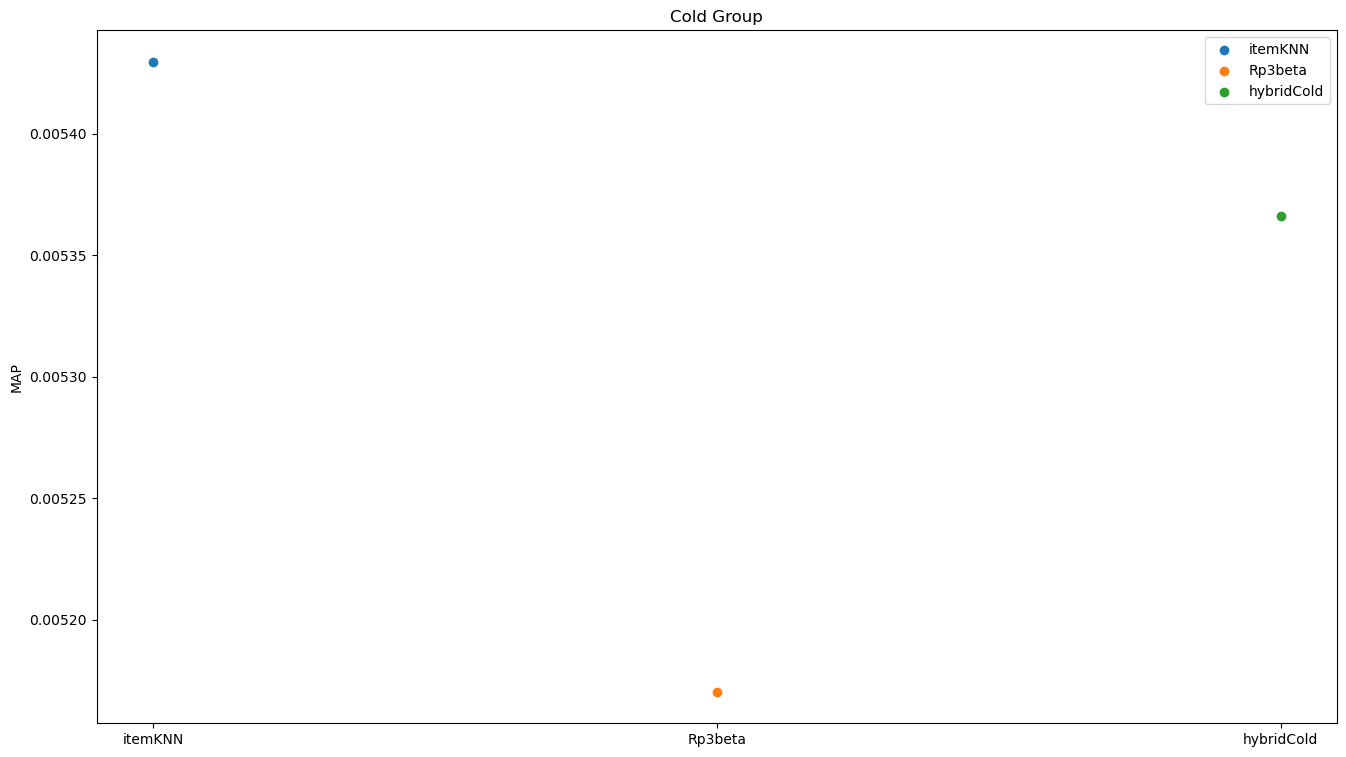

In [20]:
finalResults = {}
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict_cold.items():
    results = MAP_recommender_per_group[label]
    finalResults[label] = results
    plt.scatter(x=label, y=results, label=label)
plt.title('Cold Group')
plt.ylabel('MAP')
plt.legend()
plt.show()

## Warm Users

In [21]:
recommender_object_dict_warm = {}

hybridWarm = HybridWarm(URM_train=URM_train)
hybridWarm.fit()
recommender_object_dict_warm['hybridWarm'] = hybridWarm

RP3betaRecommender: Similarity column 24507 (100.0%), 2231.32 column/sec. Elapsed time 10.98 sec


100%|█████████▉| 24504/24507 [15:53<00:00, 25.70it/s]


In [23]:
recommender_object_dict_warm['hybridWarm'] = hybridWarm

In [24]:
MAP_recommender_per_group = {}

group_id = 1

cutoff = 10

profile_length = np.ediff1d(URM.indptr)
sorted_users = np.argsort(profile_length)

interactions = []
for i in range(41629):
    interactions.append(len(URM[i, :].nonzero()[0]))

list_group_interactions = [[0, 20], [21, 49], [50, max(interactions)]]

lower_bound = list_group_interactions[group_id][0]
higher_bound = list_group_interactions[group_id][1]

users_in_group = [user_id for user_id in range(len(interactions))
                  if (lower_bound <= interactions[user_id] <= higher_bound)]
users_in_group_p_len = profile_length[users_in_group]

users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
users_not_in_group = sorted_users[users_not_in_group_flag]

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

for label, recommender in recommender_object_dict_warm.items():
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    if label in MAP_recommender_per_group:
        MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
    else:
        MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

EvaluatorHoldout: Ignoring 933 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 16708 Users
EvaluatorHoldout: Processed 24671 (100.0%) in 23.27 sec. Users per second: 1060


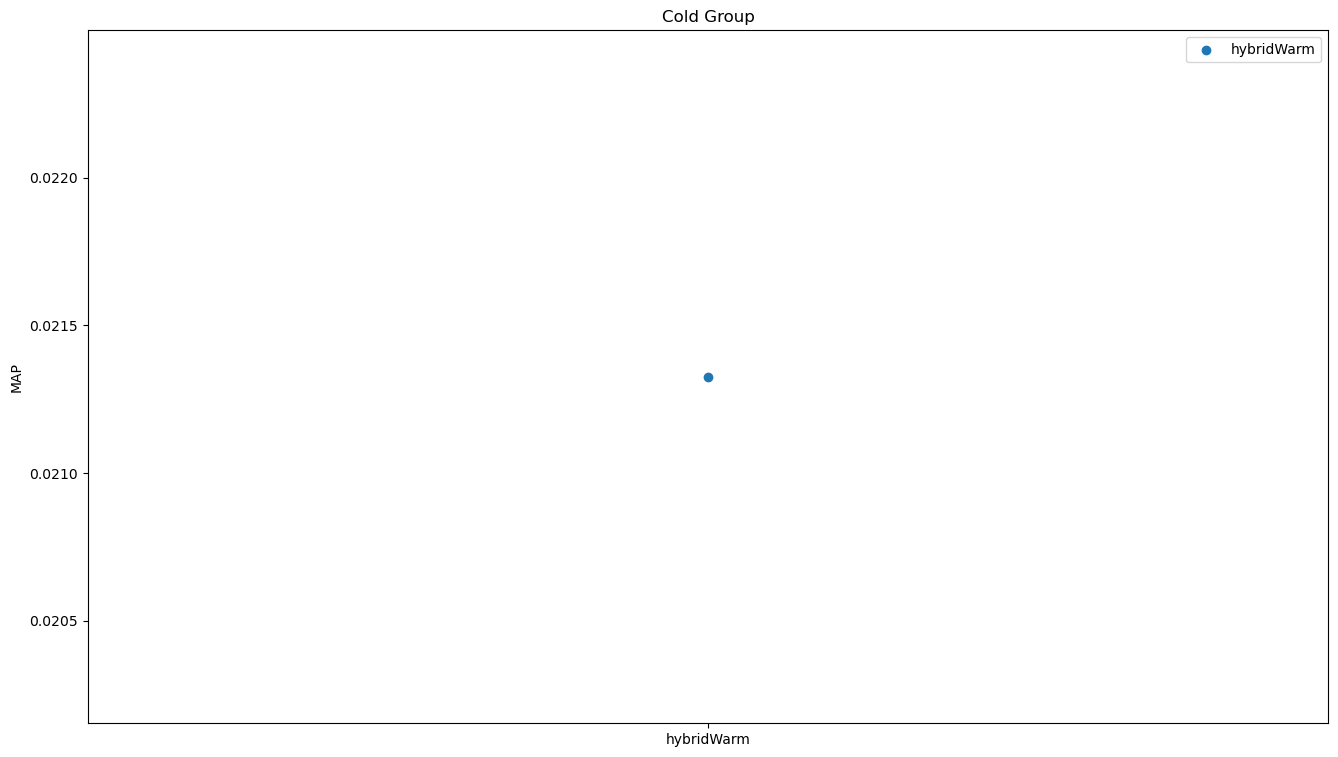

In [25]:
finalResults = {}
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict_warm.items():
    results = MAP_recommender_per_group[label]
    finalResults[label] = results
    plt.scatter(x=label, y=results, label=label)
plt.title('Cold Group')
plt.ylabel('MAP')
plt.legend()
plt.show()

In [26]:
MAP_recommender_per_group = {}

group_id = 1

cutoff = 10

profile_length = np.ediff1d(URM.indptr)
sorted_users = np.argsort(profile_length)

interactions = []
for i in range(41629):
    interactions.append(len(URM[i, :].nonzero()[0]))

list_group_interactions = [[0, 21], [22, 45], [46, max(interactions)]]

lower_bound = list_group_interactions[group_id][0]
higher_bound = list_group_interactions[group_id][1]

users_in_group = [user_id for user_id in range(len(interactions))
                  if (lower_bound <= interactions[user_id] <= higher_bound)]
users_in_group_p_len = profile_length[users_in_group]

users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
users_not_in_group = sorted_users[users_not_in_group_flag]

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

for label, recommender in recommender_object_dict_warm.items():
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    if label in MAP_recommender_per_group:
        MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
    else:
        MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

EvaluatorHoldout: Ignoring 933 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 19674 Users
EvaluatorHoldout: Processed 21751 (100.0%) in 19.06 sec. Users per second: 1141


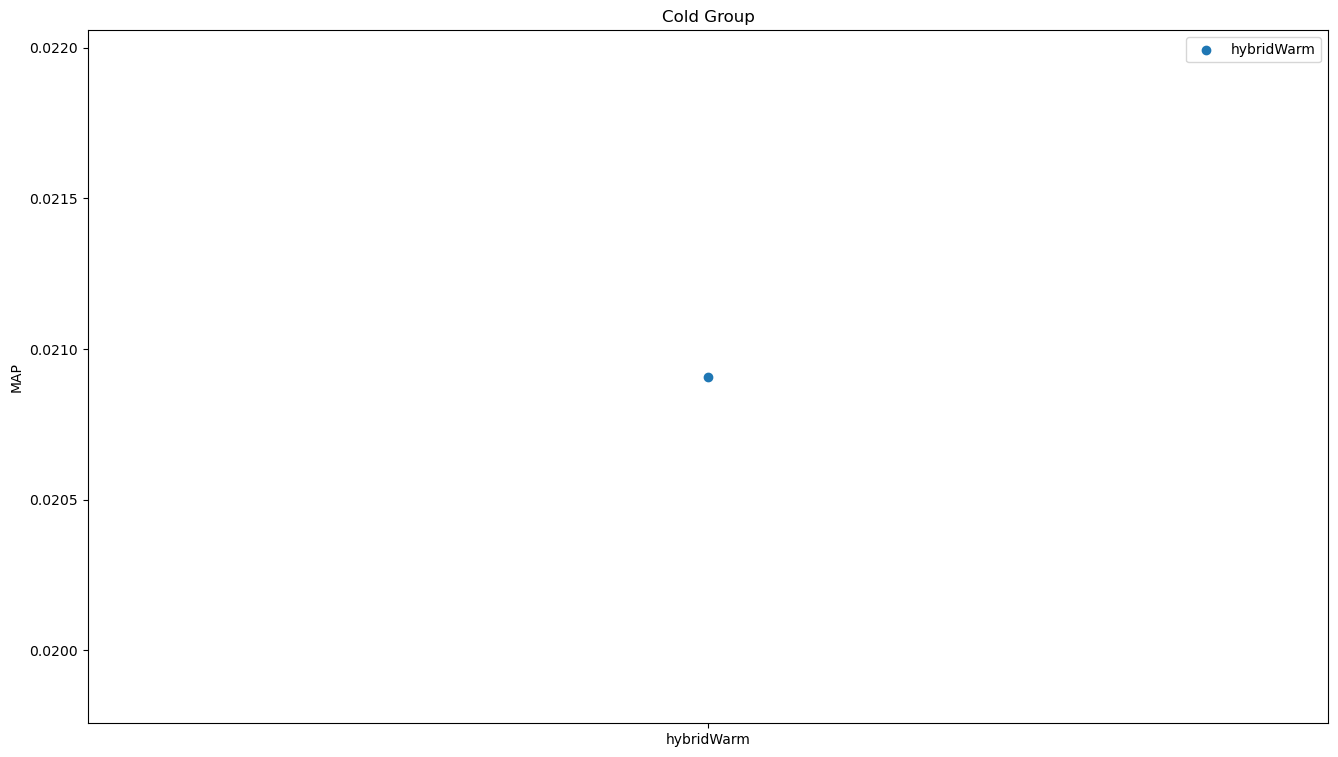

In [27]:
finalResults = {}
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict_warm.items():
    results = MAP_recommender_per_group[label]
    finalResults[label] = results
    plt.scatter(x=label, y=results, label=label)
plt.title('Cold Group')
plt.ylabel('MAP')
plt.legend()
plt.show()

In [28]:
MAP_recommender_per_group = {}

group_id = 1

cutoff = 10

profile_length = np.ediff1d(URM.indptr)
sorted_users = np.argsort(profile_length)

interactions = []
for i in range(41629):
    interactions.append(len(URM[i, :].nonzero()[0]))

list_group_interactions = [[0, 21], [22, 49], [50, max(interactions)]]

lower_bound = list_group_interactions[group_id][0]
higher_bound = list_group_interactions[group_id][1]

users_in_group = [user_id for user_id in range(len(interactions))
                  if (lower_bound <= interactions[user_id] <= higher_bound)]
users_in_group_p_len = profile_length[users_in_group]

users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
users_not_in_group = sorted_users[users_not_in_group_flag]

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

for label, recommender in recommender_object_dict_warm.items():
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    if label in MAP_recommender_per_group:
        MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
    else:
        MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

EvaluatorHoldout: Ignoring 933 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 18231 Users
EvaluatorHoldout: Processed 23191 (100.0%) in 20.86 sec. Users per second: 1112


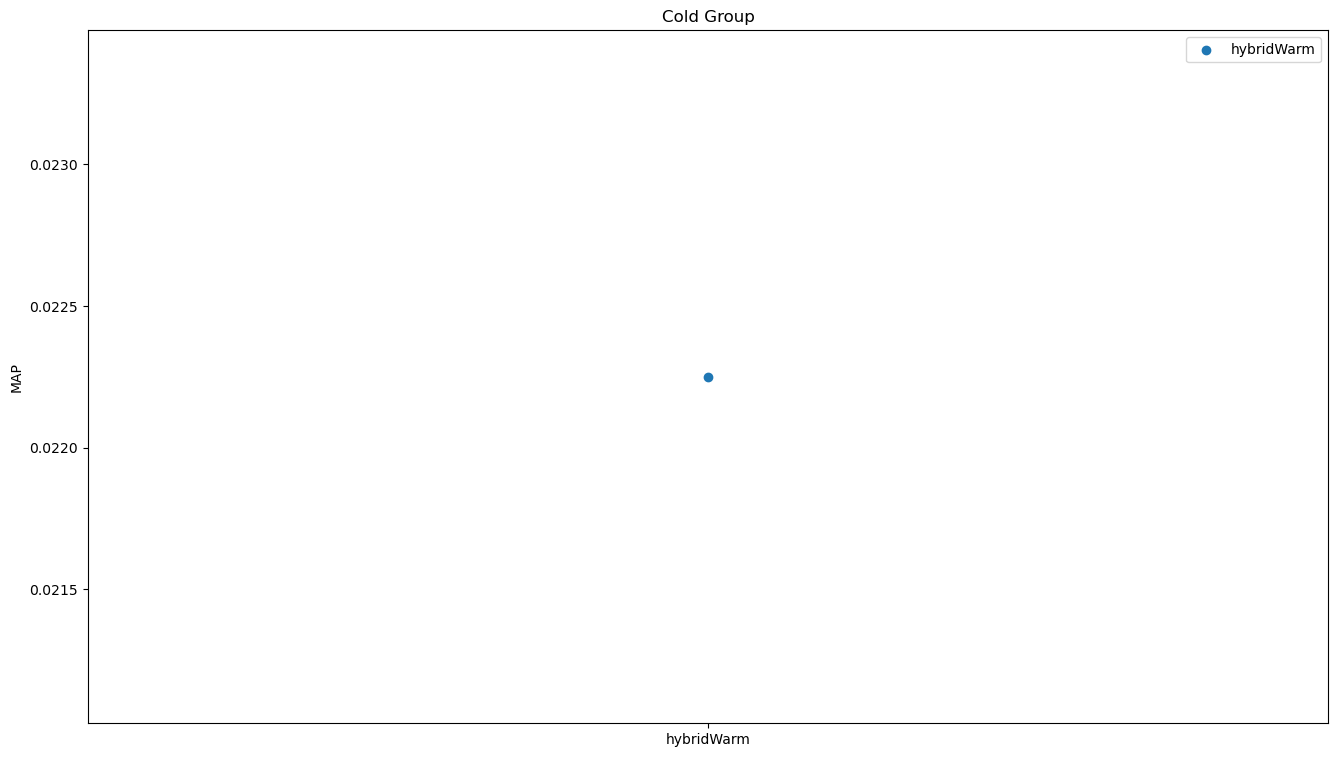

In [29]:
finalResults = {}
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict_warm.items():
    results = MAP_recommender_per_group[label]
    finalResults[label] = results
    plt.scatter(x=label, y=results, label=label)
plt.title('Cold Group')
plt.ylabel('MAP')
plt.legend()
plt.show()

## Hot Users

In [32]:
recommender_object_dict_hot = {}

hybridHot = HybridHot(URM_train=URM_train)
hybridHot.fit()
recommender_object_dict_hot['hybridHot'] = hybridHot

RP3betaRecommender: Similarity column 24507 (100.0%), 2856.46 column/sec. Elapsed time 8.58 sec


  7%|▋         | 1704/24507 [01:26<13:42, 27.71it/s]

KeyboardInterrupt: 

In [ ]:
MAP_recommender_per_group = {}

group_id = 2

cutoff = 10

profile_length = np.ediff1d(URM.indptr)
sorted_users = np.argsort(profile_length)

interactions = []
for i in range(41629):
    interactions.append(len(URM[i, :].nonzero()[0]))

list_group_interactions = [[0, 20], [21, 45], [46, max(interactions)]]

lower_bound = list_group_interactions[group_id][0]
higher_bound = list_group_interactions[group_id][1]

users_in_group = [user_id for user_id in range(len(interactions))
                  if (lower_bound <= interactions[user_id] <= higher_bound)]
users_in_group_p_len = profile_length[users_in_group]

users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
users_not_in_group = sorted_users[users_not_in_group_flag]

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

for label, recommender in recommender_object_dict_hot.items():
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    if label in MAP_recommender_per_group:
        MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
    else:
        MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

finalResults = {}
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict_hot.items():
    results = MAP_recommender_per_group[label]
    finalResults[label] = results
    plt.scatter(x=label, y=results, label=label)
plt.title('Cold Group')
plt.ylabel('MAP')
plt.legend()
plt.show()


In [ ]:
MAP_recommender_per_group = {}

group_id = 2

cutoff = 10

profile_length = np.ediff1d(URM.indptr)
sorted_users = np.argsort(profile_length)

interactions = []
for i in range(41629):
    interactions.append(len(URM[i, :].nonzero()[0]))

list_group_interactions = [[0, 20], [21, 49], [50, max(interactions)]]

lower_bound = list_group_interactions[group_id][0]
higher_bound = list_group_interactions[group_id][1]

users_in_group = [user_id for user_id in range(len(interactions))
                  if (lower_bound <= interactions[user_id] <= higher_bound)]
users_in_group_p_len = profile_length[users_in_group]

users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
users_not_in_group = sorted_users[users_not_in_group_flag]

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

for label, recommender in recommender_object_dict_hot.items():
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    if label in MAP_recommender_per_group:
        MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
    else:
        MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

finalResults = {}
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict_hot.items():
    results = MAP_recommender_per_group[label]
    finalResults[label] = results
    plt.scatter(x=label, y=results, label=label)
plt.title('Cold Group')
plt.ylabel('MAP')
plt.legend()
plt.show()
